In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(20160703)
tf.set_random_seed(20160703)

with open('ORENIST.data', 'rb') as file:
  images, labels = pickle.load(file)

  # 필터 정보를 저장하는 함수 준비
def edge_filter():
  # 세로 에지 추출 필터
  filter0=np.array(
      [[2,1,0,-1,-2],
       [3,2,0,-2,-3],
       [4,3,0,-3,-4],
       [3,2,0,-2,-3],
       [2,1,0,-1,-2]
       ]
  )/23.0
  # 가로 에지 추출
  filter1 = np.array(
      [[2,3,4,3,2],
       [1,2,3,2,1],
       [0,0,0,0,0],
       [-1,-2,-3,-2,-1],
       [-2,-3,-4,-3,-2]]
  )/23.0

  filter_array=np.zeros([5,5,1,2])
  filter_array[:,:,0,0]=filter0
  filter_array[:,:,0,1]=filter1

  # 준비한 다차원 리스트를 텐서플로의 상숫값 오브젝트로 변환하고 반환
  return tf.constant(filter_array, dtype=tf.float32)

In [0]:
# 전반부(합성곱필터, 풀링계층)에 해당하는 신경망 정의
# 합성곱 필터를 적용하는 함수 tf.nn.conv2d
# 트레이닝 알고리즘으로 파라미터를 최적화하는 것은 아니지만
# 필터를 적용하는 계산은 세션내에서 해야함.
# 차례차례 준비한다.

x=tf.placeholder(tf.float32, [None, 784])
# tf.nn.conv2d에 입력가능한 형식으로 변환
# -1은 placeholder에 저장된 데이터 개수만큼 적절하게 조정한다느 뜻
# 28x28 사이즈와, 레이어 개수 1개.
x_image=tf.reshape(x,[-1,28,28,1])


#W_conv=edge_filter()  #상수 오브젝트 가져오기
# 필터도 학습하자
W_conv=tf.Variable(tf.truncated_normal([5,5,1,2], stddev=0.1))

# stride는 이미지 크기 작게해주는 옵션
# [1,dy,dx,1] 과 같이 지정해서 
h_conv = tf.abs(tf.nn.conv2d(x_image,W_conv,
                             strides=[1,1,1,1],padding='SAME'))
# 합성곱을 적용한 후 농도가 0.2보다 작아진 곳은 모두 0으로 변경
h_conv_cutoff = tf.nn.relu(h_conv-0.2)

# 풀링계층에 해당하는 처리를 적용
# 2x2픽셀블록으로 28x28 픽셀 이미지를 2칸,2칸씩 뛰어가며
# 하나의 픽셀로 치환, 14x14로 변경된다.
h_pool=tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                      strides=[1,2,2,1], padding='SAME')

In [0]:
# 풀링계층의 출력을 두개의 노드로 된
# 전결합층에 입력하고
# 다시 소프트맥스함수를 통해 세가지 데이터로 분류

h_pool_flat = tf.reshape(h_pool,[-1,14*14*2])
num_units1=14*14*2
num_units2=2  #가로가 있는지, 세로가 있는지 노드 두개?

w2=tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2=tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)

w0=tf.Variable(tf.zeros([num_units2,3]))
b0=tf.Variable(tf.zeros([3]))
p=tf.nn.softmax(tf.matmul(hidden2,w0)+b0)


In [0]:
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t*tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p,1), tf.argmax(t,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
sess =tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
# 최적화 실행
i=0
for _ in range(200):
  i+=1
  sess.run(train_step, feed_dict={x:images, t:labels})
  if i%10==0:
    loss_val, acc_val = sess.run(
        [loss, accuracy], feed_dict={x:images, t:labels}
    )
    print('Step: %d, Loss: %f, Accuracy: %f' % (i, loss_val, acc_val))

Step: 10, Loss: 98.618576, Accuracy: 0.644444
Step: 20, Loss: 98.038155, Accuracy: 0.677778
Step: 30, Loss: 97.233788, Accuracy: 0.711111
Step: 40, Loss: 96.180771, Accuracy: 0.811111
Step: 50, Loss: 94.908409, Accuracy: 0.844444
Step: 60, Loss: 93.200798, Accuracy: 0.877778
Step: 70, Loss: 90.980301, Accuracy: 0.922222
Step: 80, Loss: 88.383949, Accuracy: 0.955556
Step: 90, Loss: 85.740112, Accuracy: 0.955556
Step: 100, Loss: 83.204849, Accuracy: 0.977778
Step: 110, Loss: 80.816376, Accuracy: 0.988889
Step: 120, Loss: 78.658554, Accuracy: 1.000000
Step: 130, Loss: 76.669159, Accuracy: 1.000000
Step: 140, Loss: 74.855209, Accuracy: 1.000000
Step: 150, Loss: 73.187653, Accuracy: 1.000000
Step: 160, Loss: 71.617470, Accuracy: 1.000000
Step: 170, Loss: 70.126663, Accuracy: 1.000000
Step: 180, Loss: 68.702347, Accuracy: 1.000000
Step: 190, Loss: 67.336197, Accuracy: 1.000000
Step: 200, Loss: 66.022049, Accuracy: 1.000000


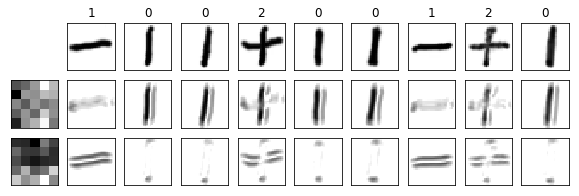

In [8]:
# 필터를 최적화한후 필터 모양 보기.
filter_vals, conv_vals=sess.run(
    [W_conv, h_conv_cutoff], feed_dict={x:images[:9]}
)
# 얻은 결과를 출력
fig=plt.figure(figsize=(10,3))

# 두가지 필터를 이미지 표시
for i in range(2):
  subplot = fig.add_subplot(3,10,10*(i+1)+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(filter_vals[:,:,0,i],
                 cmap=plt.cm.gray_r, interpolation='nearest')
  
v_max=np.max(conv_vals)

for i in range(9):

  # 원래 이미지 나타내기
  subplot=fig.add_subplot(3,10,i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                 cmap=plt.cm.gray_r, interpolation='nearest')
  
  # 세로 에지 추출 필터 적용 후 모습
  subplot=fig.add_subplot(3,10,10+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(conv_vals[i,:,:,0], vmin=0, vmax=v_max,
                 cmap=plt.cm.gray_r, interpolation='nearest')
  
  # 세로 에지 추출 필터 적용 후 모습
  subplot=fig.add_subplot(3,10,20+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(conv_vals[i,:,:,1], vmin=0, vmax=v_max,
                 cmap=plt.cm.gray_r, interpolation='nearest')
  

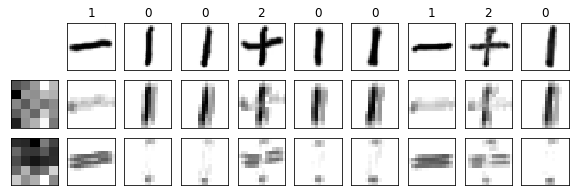

In [9]:
# 얻은 결과의 풀링계층 지난 이미지 출력
fig=plt.figure(figsize=(10,3))

pool_vals = sess.run(h_pool, feed_dict={x:images[:9]})

# 두가지 필터를 이미지 표시
for i in range(2):
  subplot = fig.add_subplot(3,10,10*(i+1)+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(filter_vals[:,:,0,i],
                 cmap=plt.cm.gray_r, interpolation='nearest')
  
v_max=np.max(conv_vals)

for i in range(9):

  # 원래 이미지 나타내기
  subplot=fig.add_subplot(3,10,i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                 cmap=plt.cm.gray_r, interpolation='nearest')
  
  # 세로 에지 추출 필터 적용 후 모습
  subplot=fig.add_subplot(3,10,10+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(pool_vals[i,:,:,0], vmin=0, vmax=v_max,
                 cmap=plt.cm.gray_r, interpolation='nearest')
  
  # 세로 에지 추출 필터 적용 후 모습
  subplot=fig.add_subplot(3,10,20+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(pool_vals[i,:,:,1], vmin=0, vmax=v_max,
                 cmap=plt.cm.gray_r, interpolation='nearest')
  